In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/Web_attack.csv')

In [3]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [4]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [7]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [11]:
selected_features_indices = selector.get_support(indices=True)

In [12]:
selected_feature_names = X.columns[selected_features_indices]

In [13]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Fwd IAT Std', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'PSH Flag Count', 'ACK Flag Count', 'Down/Up Ratio',
       'Average Packet Size', ' Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward'],
      dtype='object')


In [14]:
# Load the saved models
rf_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/web_attack_rfmodel.pkl')
svm_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/web_attack_svm.pkl')
lg_model = joblib.load('/Users/suchithkurra/Desktop/Honey_Pot Research/HoneyPot_research_code/models/web_attack_logisticreg.pkl')

In [15]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('svm', svm_model),
    ('logistic regression', lg_model)
], voting='hard')

In [16]:
# Fit the ensemble model on the training data
voting_clf.fit(X_train_selected, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('svm', SVC(kernel='linear', probability=True)),
                             ('logistic regression',
                              LogisticRegression(max_iter=1000))])

In [17]:
# Predictions
y_pred_ensemble = voting_clf.predict(X_test_selected)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Evaluation metrics
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble, average='weighted')
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')
ensemble_conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

In [19]:
# Print evaluation metrics
print("Ensemble Model Evaluation:")
print("Accuracy:", ensemble_accuracy)
print("Precision:", ensemble_precision)
print("F1-score:", ensemble_f1)
print("Confusion Matrix:")
print(ensemble_conf_matrix)

Ensemble Model Evaluation:
Accuracy: 0.9891483840528427
Precision: 0.9831747372702091
F1-score: 0.9857257289425906
Confusion Matrix:
[[33531    59]
 [  309    13]]


In [20]:
# Define class names
y_probs = voting_clf.predict_proba(X_test_selected)

class_names = ['benign', 'web attack brute force', 'web attack sql injection', 'web attack xss']
# Compute ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(voting_clf.classes_)):
    fpr, tpr, _ = roc_curve(y_test == voting_clf.classes_[i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=class_names[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

AttributeError: predict_proba is not available when voting='hard'

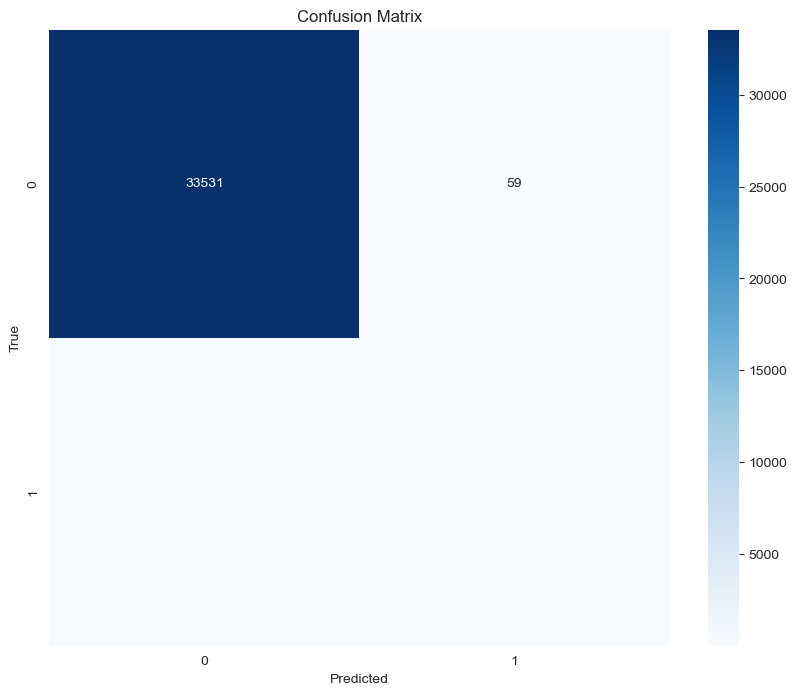

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


[[33531    59]
 [  309    13]]


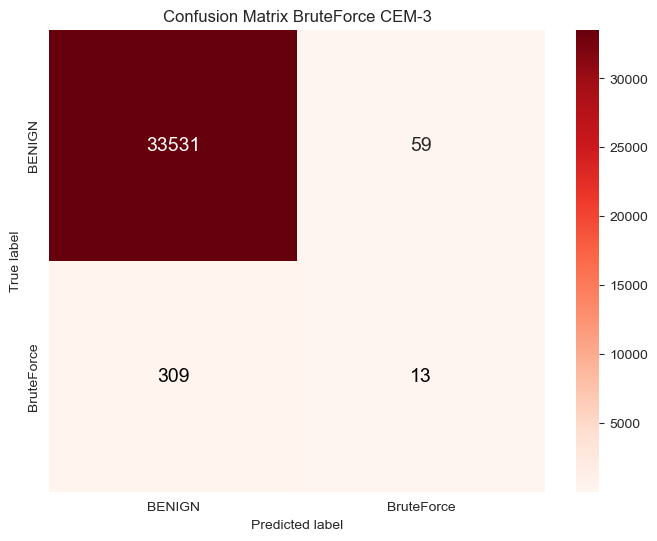

In [23]:
labels = label_encoder.classes_
print(conf_matrix)
1# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 14}, 
            xticklabels=labels, yticklabels=labels)

# Manually annotate specific cells
plt.text(1.5, 1.5, '13', fontsize=14, color='black', ha='center', va='center')
plt.text(0.5, 1.5, '309', fontsize=14, color='black', ha='center', va='center')
# plt.text(0.5, 2.5, '645', fontsize=14, color='black', ha='center', va='center')
# plt.text(1.5, 2.5, '4', fontsize=14, color='black', ha='center', va='center')
# plt.text(2.5, 1.5, '0', fontsize=14, color='black', ha='center', va='center')
# plt.text(2.5, 2.5, '583', fontsize=14, color='black', ha='center', va='center')

plt.title('Confusion Matrix BruteForce CEM-3')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [24]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 59
False Negatives: 309


In [25]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 33912


In [26]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 1.09%


In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(voting_clf, 'web_attack_ensemble_1.pkl')

# Load the model from file
# loaded_model = joblib.load('svm_model.pkl')

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_ensemble)
precision = precision_score(y_test, y_pred_ensemble)
f1 = f1_score(y_test, y_pred_ensemble)

# Create grouped bar chart
metrics = ['Accuracy', 'Precision', 'F1-score']
values = [accuracy, precision, f1]
print('accuracy : ' + str(accuracy))
print('precision : ' + str(precision))
print('f1 : ' + str(f1))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Setting y-axis limit to be between 0 and 1
plt.text(-0.1, accuracy + 0.05, f'{accuracy:.2f}', fontsize=12, color='black')
plt.text(0.9, precision + 0.05, f'{precision:.2f}', fontsize=12, color='black')
plt.text(1.9, f1 + 0.05, f'{f1:.2f}', fontsize=12, color='black')
plt.show()